# Recommender Systems

In this exercise we evaluated various recommender systems and tried to improve it using different techniques. The Amazon fine food data were used for this practices. This data were acquired from kaggle. 

# Step 1: Importing dependencies, loading data and EDA

In [193]:
# importing dependencies

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle

%matplotlib inline

In [17]:
# loading data

path = "data_file"
df = pd.read_csv(os.path.join(path, "reviews.csv"))
df_copy = df.copy()

In [3]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [4]:
# Exploratory Data Analysis

# number of unique users and items
n_users = df.UserId.unique().shape[0]
n_items = df.ProductId.unique().shape[0]
print(f"This dataset has {n_users} numbers of unique users, and includes ratings of {n_items} items")

This dataset has 256059 numbers of unique users, and includes ratings of 74258 items


In [5]:
# User's rating counts
user_freq = df[['UserId', 'ProductId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_ratings']
user_freq.sort_values('n_ratings', ascending=False).head(10)

,UserId,n_ratings
182011,A3OXHLG6DIBRW8,448
65586,A1YUL9PCJR3JTY,421
252275,AY12DBB0U420B,389
82919,A281NPSIMI1C2R,365
66162,A1Z54EM24Y40LL,256
55736,A1TMAVN4CEM8U8,204
110863,A2MUGFV2TDQ47K,201
191283,A3TVZM3ZIXG8YW,199
183161,A3PJZ8TU8FDQ1K,178
238453,AQQLWCMRNDFGI,176


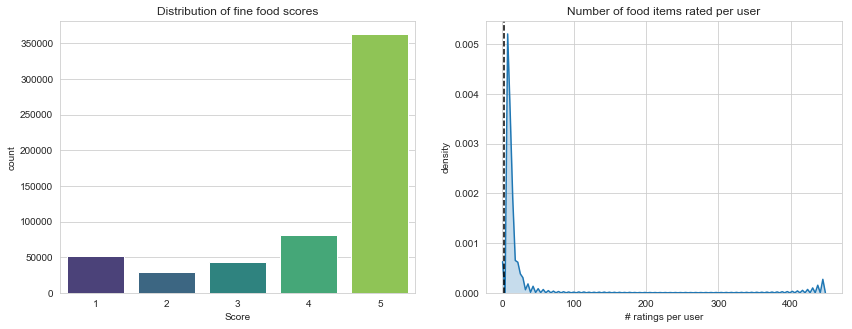

In [6]:
# Distribution of rating and number of ratings per user
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="Score", data=df, palette="viridis")
plt.title("Distribution of fine food scores")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of food items rated per user")
plt.show()

In [7]:
# number of users with only 1 ratings
n_users_one = user_freq[user_freq['n_ratings']==1].shape[0]
print(f"Out of {n_users} total unique users, {n_users_one} ({round((n_users_one/n_users)*100,2)}%) users only rated one item.")

# number of users with 2 ratings
n_users_two = user_freq[user_freq['n_ratings']==2].shape[0]
print(f"Out of {n_users} total unique users, {n_users_two} ({round((n_users_two/n_users)*100,2)}%) users rated two items.")

# number of users with 3 ratings
n_users_three = user_freq[user_freq['n_ratings']==3].shape[0]
print(f"Out of {n_users} total unique users, {n_users_three} ({round((n_users_three/n_users)*100,2)}%) users rated three items.")

user_freq.describe()

Out of 256059 total unique users, 175391 (68.5%) users only rated one item.
Out of 256059 total unique users, 32658 (12.75%) users rated two items.
Out of 256059 total unique users, 13828 (5.4%) users rated three items.


,n_ratings
count,256059.000000
mean,2.220012
std,4.443361
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,448.000000


As shown in the above graphs: 
(1) The reviews tend to be more positive (biased toward more positive reviews)
(2) Very few people provides more than 1 reviews (which leads to a very sparse matrix later developing our recommender)

In [8]:
# Item rating counts
item_freq = pd.DataFrame(df['ProductId'].value_counts().reset_index())
item_freq.columns = ['ProductId', 'n_ratings']
item_freq.sample(10)

,ProductId,n_ratings
11659,B001E5E38K,9
39638,B0092VQC3W,2
49761,B0008G2ENC,1
23958,B000I62U0O,4
40398,B0031TX7NY,2
30741,B000M5SHSK,3
50957,B0006MU8SG,1
48564,B003FPR1QS,1
66095,B001E0KVZ4,1
187,B003FDC2I2,257


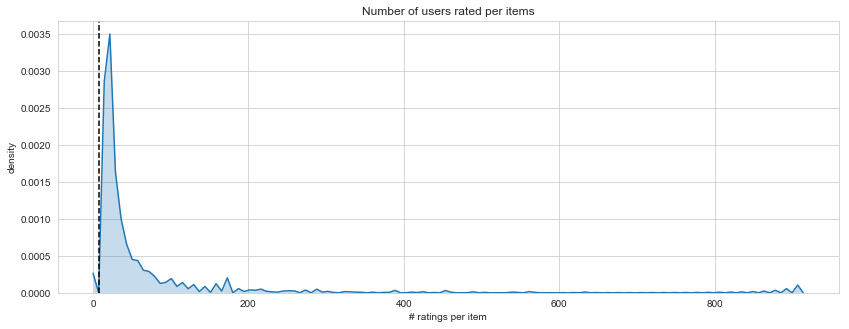

In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,1,1)
ax = sns.kdeplot(item_freq['n_ratings'], shade=True, legend=False)
plt.axvline(item_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per item")
plt.ylabel("density")
plt.title("Number of users rated per items")
plt.show()

In [10]:
# number of items with 1 ratings
n_items_one = item_freq[item_freq['n_ratings']==1].shape[0]
print(f"Out of {n_items} total unique items, {n_items_one} ({round((n_items_one/n_items)*100,2)}%) itmes only recieved one score.")

# number of items with 2 ratings
n_items_two = item_freq[item_freq['n_ratings']==2].shape[0]
print(f"Out of {n_items} total unique items, {n_items_two} ({round((n_items_two/n_items)*100,2)}%) itmes only recieved two scores.")

# number of items with 3 ratings
n_items_three = item_freq[item_freq['n_ratings']==3].shape[0]
print(f"Out of {n_items} total unique items, {n_items_three} ({round((n_items_three/n_items)*100,2)}%) itmes only recieved three score.")

item_freq.describe()

Out of 74258 total unique items, 30408 (40.95%) itmes only recieved one score.
Out of 74258 total unique items, 12262 (16.51%) itmes only recieved two scores.
Out of 74258 total unique items, 6849 (9.22%) itmes only recieved three score.


,n_ratings
count,74258.000000
mean,7.655121
std,26.453485
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,913.000000


Above statistics shows that about 60% of the items have one or more ratings

In [12]:
# Now checking whether we have more than one user-item interactions
df_grouped_interaction = pd.DataFrame(df.groupby(['UserId','ProductId']).size().reset_index())
df_grouped_interaction.columns = ['UserId','ProductId','count']
print(f"There are {df_grouped_interaction[df_grouped_interaction['count']>1].shape[0]} user_item interactions that occured more than one time.")

There are 5859 user_item interactions that occured more than one time.


In [18]:
# to deal with this group we use aggregate functions
# Datasets with aggregated measures
df['Summary'] = df['Summary'].astype(str).apply(lambda x: x.split())
df_agg = df.groupby(['UserId', 'ProductId']).agg({'HelpfulnessNumerator': 'mean',
                                                  'HelpfulnessDenominator':'mean', 
                                                  'Score':'mean', 
                                                  'Time': 'max', 
                                                  'Summary':'sum',
                                                  'Text':'-'.join}).reset_index()
df_agg.head()

,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,#oc-R103C0QSV1DF5E,B006Q820X0,1.0,2.0,5.0,1343088000,"[Great, for, the, Price]",I have to say I was a little apprehensive to b...
1,#oc-R109MU5OBBZ59U,B008I1XPKA,0.0,1.0,5.0,1350086400,"[AWESOME, Coffee!!!!]",Received my free K cups as a sample promotion ...
2,#oc-R10LFEMQEW6QGZ,B008I1XPKA,0.0,1.0,5.0,1345939200,"[Brooklyn, Bean, Roastery, Breakfast, Blend, K...",Brooklyn Bean Roastery Blend K-Cups are great ...
3,#oc-R10LT57ZGIB140,B0026LJ3EA,0.0,0.0,3.0,1310601600,"[Some, damage]",The shipment of the dog food was quick. Howev...
4,#oc-R10UA029WVWIUI,B006Q820X0,0.0,0.0,1.0,1342483200,"[Less, than, satisfactory., I, gave, the, Broo...","Brooklyn ""French Roast"" K-Cup Coffee is not on..."


In [59]:
# now need to identify cases with only one interactions (per both item and user)
# this can be particularly of interest since we may not be able to judge the accuracy of those cases
# number of items and individuals with only one count of ratings

one_rating_user = user_summary[user_summary['Scorecount'] == 1]
one_rating_user_full = pd.merge(one_rating_user, df_agg[['UserId', 'ProductId']], on = 'UserId')

one_rating_item = item_summary[item_summary['Scorecount'] == 1]
one_rating_item_full = pd.merge(one_rating_item, df_agg[['UserId', 'ProductId']], on = 'ProductId')


# to find 1-1 user-interaction we use inner merge
one_user_item = pd.merge(one_rating_user_full[['UserId','ProductId']], one_rating_item_full[['ProductId','UserId']], 
                         how='inner', on=['UserId', 'ProductId'])

# now check whether the size of one_user_item is less than or equal to min (size of user, size of item)
print(one_user_item.shape[0] < min(one_rating_user_full.shape[0], one_rating_item_full.shape[0]))

True


In [160]:
# now removing those cases
print(f"Out of {df_agg.shape[0]} user_interaction we found {one_user_item.shape[0]} interactions that have 1-1 user-item")

# # We created a dataset without those 1-1 interaction (I called them cold-cold start)
one_user_item_uid = list(one_user_item['UserId'])
df_clean = df_agg[~df_agg['UserId'].isin(one_user_item_uid)]
print(df_clean.shape[0] == (df_agg.shape[0] - len(one_user_item_uid)))
df_clean.head()                   

Out of 560804 user_interaction we found 14675 interactions that have 1-1 user-item
True


In [66]:
# average ratings
mean_rating = df_clean.groupby('ProductId')[['Score']].mean()
lowest_rated = mean_rating['Score'].idxmin()
highest_rated = mean_rating['Score'].idxmax()
df_clean[df_clean['ProductId']==highest_rated]

,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
404281,A3QD68O22M2XHQ,2841233731,0.0,0.0,5.0,1345852800,"[Great, recipe, book, for, my, babycook]",This book is easy to read and the ingredients ...


however, the average scores depends to the number of times each item has rated by users. A better measure of item popularity in this case will be the Bayesian Average.

In [70]:
food_stats = df_clean.groupby('ProductId')[['Score']].agg(['count', 'mean'])
food_stats.columns = food_stats.columns.droplevel()

In [86]:
c = food_stats['count'].mean()
m = food_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (c*m + ratings.sum())/(c+ratings.count())
    return bayesian_avg

bayesian_mean_ratings = df_clean.groupby('ProductId')['Score'].agg(bayesian_avg).reset_index()
bayesian_mean_ratings.columns = ['ProductId', 'Bayesian_avg']
bayesian_mean_ratings.sort_values('Bayesian_avg').head(1)
bayesian_mean_ratings.sort_values('Bayesian_avg').tail(1)

# add a line showing top 10 items 

,ProductId,Bayesian_avg
6740,B000ED9L9E,4.914167


In [80]:
most_pop_item = df_clean[df_clean.ProductId=='B000ED9L9E']
least_pop_item = df_clean[df_clean.ProductId=='B006N3I69A']

In [81]:

# perhaps use it later when we find to have time-dependent path
# 1) datasets with one user-item interaction
# df_one_rate_per_user = pd.merge(df[['UserId', 'ProductId']].drop_duplicates(keep=False), 
#                                 df, 
#                                 how='inner', 
#                                 on=['UserId', 'ProductId'])    
# print(f"There are {df_one_rate_per_user.shape[0]} user-item interactions which only occured once in the dataset.")

# Step 2: Developing Recommender System

In this step we evaluated various approaches to develop a recommender system. We further compared the result of these analysis using explicit score provided by users, using latent semantic analysis of the text/summary, and also combination of both.

In [172]:
# # Data preparation for explicit feedback recommender system
# df_explicit = df_clean[['UserId', 'ProductId', 'Score']]
# # df_explicit = df_explicit.pivot(index='UserId', columns='ProductId').Score
# df_explicit = df_explicit.pivot(index='ProductId', columns='UserId', values='Score').fillna(0)


In [101]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['UserId'].nunique()
    M = df['ProductId'].nunique()

    user_mapper = dict(zip(np.unique(df["UserId"]), list(range(N))))
    item_mapper = dict(zip(np.unique(df["ProductId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["UserId"])))
    item_inv_mapper = dict(zip(list(range(M)), np.unique(df["ProductId"])))
    
    user_index = [user_mapper[i] for i in df['UserId']]
    item_index = [item_mapper[i] for i in df['ProductId']]

    X = csr_matrix((df["Score"], (item_index, user_index)), shape=(M, N))
    
    return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper

In [102]:
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_X(df_clean)

In [111]:
# to compute sparsity of X,  we divied number of # non-zero element by total element in X
sparsity =X.count_nonzero()/(X.shape[0] * X.shape[1])
print(f"The sparsity of X is {round(sparsity*100, 5)}%")

The sparsity of X is 0.0038%


Since the sparsity is very high, we had to remove some of the cold starts cases.

In [450]:
seed=42

# from items
n_item_drop = 50

df_clean_item = df_clean.groupby('ProductId').size().reset_index(name='count')
# removing ~X% of each group randomly
item_n_score =df_clean_item[df_clean3['count']<n_item_drop]
sampled_item_n_score = item_n_score.sample(frac=.99 , random_state=seed, replace=False)['ProductId'].reset_index()
sampled_item_n_score = list(sampled_item_n_score['ProductId'])
print(f"number of items with less than {n_item_drop} rating: {item_n_score.shape[0]}, from which we dropped {len(sampled_item_n_score)} cases")
df_clean_final = df_clean[~df_clean['ProductId'].isin(sampled_item_n_score)]
print(df_clean_final.shape[0])
      
# from users      
n_user_drop = 9

df_clean_user = df_clean_final.groupby('UserId').size().reset_index(name='count')
# removing ~X% of each group randomly
user_n_score =df_clean_user[df_clean_user['count']<n_user_drop]
sampled_user_n_score = user_n_score.sample(frac=.9 , random_state=seed, replace=False)['UserId'].reset_index()
sampled_user_n_score = list(sampled_user_n_score['UserId'])
print(f"number of users with less than {n_user_drop} rating: {user_n_score.shape[0]}, from which we dropped {len(sampled_user_n_score)} cases")     
df_clean_final = df_clean_final[~df_clean_final['UserId'].isin(sampled_user_n_score)]
print(df_clean_final.shape[0])

number of items with less than 50 rating: 57761, from which we dropped 57183 cases
238701
number of users with less than 9 rating: 75169, from which we dropped 67652 cases
96221


In [451]:
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_X(df_clean_final)

In [452]:
sparsity =X.count_nonzero()/(X.shape[0] * X.shape[1])
print(f"The sparsity of X is {round(sparsity*100, 5)}%")

The sparsity of X is 0.3479%


In [453]:
df_clean_final.head()

,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2,#oc-R10LFEMQEW6QGZ,B008I1XPKA,0.0,1.0,5.0,1345939200,"[Brooklyn, Bean, Roastery, Breakfast, Blend, K...",Brooklyn Bean Roastery Blend K-Cups are great ...
48,#oc-R162D7S0A880MV,B005HG9ERW,0.0,0.0,5.0,1344211200,"[Neutral, taste,, low, pH]",For those looking for a non-flavoured water be...
49,#oc-R162D7S0A880MV,B005HG9ESG,0.0,0.0,5.0,1344211200,"[Neutral, taste,, low, pH]",For those looking for a non-flavoured water be...
50,#oc-R162D7S0A880MV,B005HG9ET0,0.0,0.0,5.0,1344211200,"[Neutral, taste,, low, pH]",For those looking for a non-flavoured water be...
87,#oc-R1CSQFEG6ZI93U,B006Q820X0,2.0,3.0,5.0,1337558400,"[Good, flavor]",Let me preface this review by saying I drink i...


We decided to remove a large proportion of both items with less than 50 ratings and users who provided less than 9 ratings. 
We did not remove all of them to keep some cold cases in our sample.
Even after this removal the sparsity is still very high, which eventually affect our final model. 
Here we replicate some of the EDA on the new dataset.

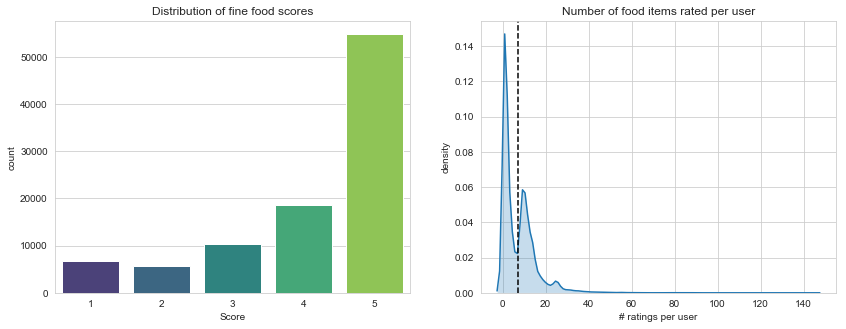

In [456]:
# final sample size and EDA
df_clean_final['Score'] = df_clean_final.Score.astype('int32')

# User's rating counts
user_freq = df_clean_final[['UserId', 'ProductId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_ratings']
user_freq.sort_values('n_ratings', ascending=False).head(10)

# Distribution of rating and number of ratings per user
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="Score", data=df_clean_final, palette="viridis")
plt.title("Distribution of fine food scores")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of food items rated per user")
plt.show()

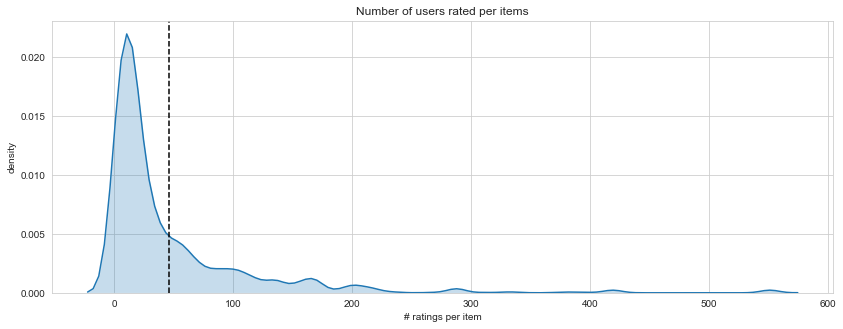

In [458]:
# Item rating counts
item_freq = df_clean_final.groupby('ProductId').size().reset_index(name='n_ratings')

sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,1,1)
ax = sns.kdeplot(item_freq['n_ratings'], shade=True, legend=False)
plt.axvline(item_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per item")
plt.ylabel("density")
plt.title("Number of users rated per items")
plt.show()

In [460]:
food_stats = df_clean_final.groupby('ProductId')[['Score']].agg(['count', 'mean'])
food_stats.columns = food_stats.columns.droplevel()

,count,mean
ProductId,,
7310172001,167,4.754491
7310172101,167,4.754491
B00004CI84,27,4.185185
B00004CXX9,25,4.120000
B00004RAMY,16,3.937500


In [469]:
c = food_stats['count'].mean()
m = food_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (c*m + ratings.sum())/(c+ratings.count())
    return bayesian_avg

bayesian_mean_ratings = df_clean_final.groupby('ProductId')['Score'].agg(bayesian_avg).reset_index()
bayesian_mean_ratings.columns = ['ProductId', 'Bayesian_avg']
bayesian_mean_ratings.sort_values('Bayesian_avg').head(1)
bayesian_mean_ratings.sort_values('Bayesian_avg').tail(1)

,ProductId,Bayesian_avg
0,7310172001,4.637453


In [ ]:
# We can use the above number to create the recommender system based on topn popular food



## Now development of Recommender System

To make many of the common recommender system

In [ ]:
# we first use several basi

In [470]:
df_clean_final.shape

(96221, 8)

In [546]:
# using surprise package for basic 

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split, KFold
from surprise.model_selection import GridSearchCV

In [473]:
# first initialzing our data object and loading the dataset 
# The load_from_df requires a dataset and internally make the sparse matrix

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_clean_final[['UserId', 'ProductId', 'Score']], reader)

In [493]:
# there are a number of options for creating a train, validation and test sets
# Below you can see both approaches

# 1) using Surprise approach
trainset, testset = train_test_split(data, test_size=.2)


# 2) masking some of the items and then predict them



In [507]:
# Another topic that worth a discussion here is the metric based on which we can decide abour model performance. There
# are number of different metrics that can be used including
# RMSE
#...


def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [651]:
# using a Random Perdictor  
# This algorithm predict random rating based on the distribution of the training set, which is assumed to be normal.

algo_normal = NormalPredictor()

result_random = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_normal = algo_normal.fit(trainset).test(testset)

Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9350  0.9412  0.9350  0.9346  0.9397  0.9371  0.0028  
RMSE (trainset)   0.8823  0.8812  0.8821  0.8822  0.8812  0.8818  0.0005  
Fit time          0.05    0.05    0.05    0.05    0.05    0.05    0.00    
Test time         0.08    0.08    0.08    0.09    0.08    0.08    0.00    


In [519]:
# To better evaluate this model
df_random = pd.DataFrame(predictions_normal, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_random['Iu'] = df_random.uid.apply(get_Iu)
df_random['Ui'] = df_random.iid.apply(get_Ui)
df_random['err'] = abs(df_random.est - df_random.rui)

In [522]:
best_predictions = df_random.sort_values(by='err')[:10]
worst_predictions = df_random.sort_values(by='err')[-10:]

In [523]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
9622,A2HNVHNTAE60KT,B008JKU2CO,5.0,5.0,{'was_impossible': False},5,119,0.0
9975,ADEZOPMPKK146,B004X3VRLG,5.0,5.0,{'was_impossible': False},15,90,0.0
9955,A3J4FP9Z0J0535,B003CK0XC0,5.0,5.0,{'was_impossible': False},11,123,0.0
9941,A2V373EQ0LXUUW,B006N3IG4K,5.0,5.0,{'was_impossible': False},8,340,0.0
9929,A1Z7Y2GMAP9SRY,B002IEZJMA,5.0,5.0,{'was_impossible': False},24,321,0.0
9928,A3VKBFC5K2INR4,B001IZM92S,5.0,5.0,{'was_impossible': False},36,7,0.0
2409,A29NA3RIZT5CH8,B003VXHGDM,5.0,5.0,{'was_impossible': False},7,336,0.0
9926,A2GYDZ6RN1UWJM,B002AQ0OS0,5.0,5.0,{'was_impossible': False},8,17,0.0
9917,A1RCQ6WRMXE0ZN,B001CWV4RS,5.0,5.0,{'was_impossible': False},6,33,0.0
2414,A3MVXSMNSKKLCN,B003VXHGPK,5.0,5.0,{'was_impossible': False},6,339,0.0


In [540]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
15305,A2X9PNKZRBD1UC,B007M832YY,5.0,1.0,{'was_impossible': False},8,442,4.0
16285,A1B5T3IUHLZ2UU,B004FGWU9O,1.0,5.0,{'was_impossible': False},6,348,4.0
1122,A8FBU7CIOQEH8,B000CQG89Y,1.0,5.0,{'was_impossible': False},8,132,4.0
17177,ATXDX08LIQLS,B0039556K2,1.0,5.0,{'was_impossible': False},6,39,4.0
11219,A1VBPM0TO2NWCM,B000CQG8B2,1.0,5.0,{'was_impossible': False},6,25,4.0
18313,AFU4E0FKGUQ7A,B00412W76S,1.0,5.0,{'was_impossible': False},19,127,4.0
16294,A2D7X9N3IV3S7B,B004U43ZO0,1.0,5.0,{'was_impossible': False},23,134,4.0
5936,A14SOW889A4TAT,B000LKXBL4,1.0,5.0,{'was_impossible': False},11,162,4.0
16304,AAJAN7GE1QUUG,B001BM3C4M,1.0,5.0,{'was_impossible': False},10,96,4.0
8077,AHAJOKPTCGT4N,B007RTR8UC,5.0,1.0,{'was_impossible': False},2,44,4.0


In [541]:
df_clean_final[(df_clean_final['UserId'] == 'A2X9PNKZRBD1UC') & (df_clean_final['ProductId'] == 'B007M832YY')]

,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
284606,A2X9PNKZRBD1UC,B007M832YY,1.0,1.0,5,1300492800,"[A, healthy, alternative]",These are a much healthy alternative to most c...


In [ ]:
# now we are using a collaborative filtering approach based on nearest neighborhood 

# Using KNN

In [580]:
# using KNN
# knn_basic

param_grid = {'k': [5, 10, 15, 30, 60],
              'sim_options': {'name': ['msd', 'cosine','pearson_baseline'],
                              'min_support': [1, 5, 10],
                              'user_based': [False, True]}
              }

gs_knn_basic = GridSearchCV(KNNBasic, param_grid = param_grid, measures=['rmse'], n_jobs=1, cv=5)

In [581]:
gs_knn_basic.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [599]:
print(f"The best model rmse score is {gs_knn_basic.best_score['rmse']}")
print(f"The best model parameters are {gs_knn_basic.best_params['rmse']}")

The best model rmse score is 0.6141432178084388
The best model parameters are {'k': 15, 'sim_options': {'name': 'pearson_baseline', 'min_support': 1, 'user_based': False}}


In [597]:
# Another way to check the resuls is to look at the result table from each iterations
results_df = pd.DataFrame.from_dict(gs_knn_basic.cv_results)
results_df.sort_values('mean_test_rmse').head(5)

# looking at result we found that pearson baselines seems to produce the lowest rmse, although the result of other approaches
# seems to be fairly comparable with pearson baseline 

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
48,0.611972,0.608661,0.614911,0.618864,0.616308,0.614143,0.003531,1,0.398585,0.004362,0.325609,0.001495,"{'k': 15, 'sim_options': {'name': 'pearson_bas...",15,"{'name': 'pearson_baseline', 'min_support': 1,..."
66,0.611994,0.608691,0.614899,0.618891,0.616329,0.614161,0.003528,2,0.396787,0.003857,0.318214,0.003109,"{'k': 30, 'sim_options': {'name': 'pearson_bas...",30,"{'name': 'pearson_baseline', 'min_support': 1,..."
84,0.611994,0.608691,0.614899,0.618891,0.616329,0.614161,0.003528,3,0.394997,0.003104,0.308999,0.003957,"{'k': 60, 'sim_options': {'name': 'pearson_bas...",60,"{'name': 'pearson_baseline', 'min_support': 1,..."
30,0.612137,0.608767,0.615232,0.618976,0.616254,0.614273,0.003517,4,0.391192,0.004806,0.387205,0.115925,"{'k': 10, 'sim_options': {'name': 'pearson_bas...",10,"{'name': 'pearson_baseline', 'min_support': 1,..."
12,0.614413,0.609251,0.616814,0.621181,0.618399,0.616012,0.004033,5,0.393178,0.003309,0.307222,0.002562,"{'k': 5, 'sim_options': {'name': 'pearson_base...",5,"{'name': 'pearson_baseline', 'min_support': 1,..."


In [600]:
# here we compared the best algorithm with the algorithm that we think is OK and more reasonable
# first the result of best algorthm

algo_knn_basic_best = gs_knn_basic.best_estimator['rmse']

result_knn_basic_best = cross_validate(algo_knn_basic_best, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_knn_basic_best = algo_knn_basic_best.fit(trainset).test(testset)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6228  0.6144  0.6032  0.6197  0.6162  0.6152  0.0067  
MAE (testset)     0.2484  0.2458  0.2399  0.2459  0.2469  0.2454  0.0029  
RMSE (trainset)   0.0582  0.0541  0.0579  0.0574  0.0562  0.0568  0.0015  
MAE (trainset)    0.0165  0.0156  0.0165  0.0161  0.0161  0.0161  0.0003  
Fit time          0.33    0.32    0.32    0.32    0.30    0.32    0.01    
Test time         0.33    0.34    0.34    0.34    0.31    0.33    0.01    
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [604]:
# here we compared the best algorithm with the algorithm that we think is OK and more reasonable
# Now using KNN with cosine similarity and k=10

algo_knn_basic_cosine = KNNBasic(k=10, sim_options={'name':'cosine', 'min_support':5, 'user_based':False})

result_algo_knn_basic_cosine= cross_validate(algo_knn_basic_cosine, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_algo_knn_basic_cosine = algo_knn_basic_cosine.fit(trainset).test(testset)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6330  0.6500  0.6480  0.6329  0.6545  0.6437  0.0090  
MAE (testset)     0.2822  0.2921  0.2922  0.2841  0.2951  0.2892  0.0051  
RMSE (trainset)   0.4183  0.4112  0.4165  0.4179  0.4146  0.4157  0.0026  
MAE (trainset)    0.1553  0.1516  0.1536  0.1550  0.1526  0.1536  0.0014  
Fit time          0.21    0.22    0.22    0.22    0.22    0.22    0.00    
Test time         0.33    0.34    0.34    0.35    0.33    0.34    0.01    
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [605]:
# here we expand the knn approach by taking into account 
# (1) the mean of ratings of each user/item and 
# (2) z-score normalization score
# (3) baseline rating

In [606]:
# using KNN with mean of ratings

param_grid = {'k': [5, 10, 20],
              'sim_options': {'name': ['cosine','pearson_baseline'],
                              'min_support': [5, 10],
                              'user_based': [False, True]}
              }

gs_knn_mean = GridSearchCV(KNNWithMeans, param_grid = param_grid, measures=['rmse'], n_jobs=-1, cv=5)

In [ ]:
gs_knn_mean.fit(data)

In [624]:
print(f"The best model rmse score is {gs_knn_mean.best_score['rmse']}")
print(f"The best model parameters are {gs_knn_mean.best_params['rmse']}")
      
print("Now estimating the model using the best estimators...")
algo_knn_mean_best = gs_knn_mean.best_estimator['rmse']

result_knn_mean_best = cross_validate(algo_knn_mean_best, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_knn_mean_best = algo_knn_mean_best.fit(trainset).test(testset)

The best model rmse score is 0.5966934436978567
The best model parameters are {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}}
Now estimating the model using the best estimators...
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6008  0.5776  0.5963  0.5988  0.6042  0.5955  0.0093  
MAE (testset)     0.2675  0.2582  0.2662  0.2668  0.2678  0.2653  0.0036  
RMSE (trainset)   0.0582  0.0593  0.0594  0.0601  0.0585  0.0591  0.0007  
MAE (trainset)    0.0278  0.0283  0.0278  0.0275  0.0277  0.0278  0.0003  
Fit time          0.31    0.33    0.36    0.35    0.32    0.34    0.02    
Test time         0.36    0.39    0.40    0.40    0.38    0.39    0.02    
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [621]:
# using KNN with zscore
gs_knn_zscore = GridSearchCV(KNNWithZScore, param_grid = param_grid, measures=['rmse'], n_jobs=-1, cv=5)
gs_knn_zscore.fit(data)

In [625]:
print(f"The best model rmse score is {gs_knn_zscore.best_score['rmse']}")
print(f"The best model parameters are {gs_knn_zscore.best_params['rmse']}")
      
print("Now estimating the model using the best estimators...")
algo_knn_zscore_best = gs_knn_zscore.best_estimator['rmse']

result_knn_zscore_best = cross_validate(algo_knn_zscore_best, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_knn_zscore_best = algo_knn_zscore_best.fit(trainset).test(testset)

The best model rmse score is 0.6075508753997347
The best model parameters are {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}}
Now estimating the model using the best estimators...
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5958  0.6135  0.6006  0.6081  0.6027  0.6041  0.0061  
MAE (testset)     0.2724  0.2774  0.2733  0.2752  0.2731  0.2743  0.0018  
RMSE (trainset)   0.0656  0.0641  0.0634  0.0635  0.0626  0.0638  0.0010  
MAE (trainset)    0.0308  0.0295  0.0296  0.0293  0.0295  0.0297  0.0005  
Fit time          0.44    0.39    0.41    0.40    0.38    0.40    0.02    
Test time         0.39    0.42    0.40    0.43    0.43    0.41    0.01    
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [636]:
# using KNN with baseline rating

sim_options = {'names': 'pearson_baseline', 
               'user_based': False,
               'min_support': 5}

# als method
bsl_option_als = {
    'method':'als',
    'n_epochs': 10,
    'reg_u':12,
    'reg_i':5
}



algo_knn_baseline_als = KNNBaseline(sim_options = sim_options, bsl_options = bsl_option_als)

result_knn_baseline_als = cross_validate(algo_knn_baseline_als, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1,)
predictions_baseline_als = algo_knn_baseline_als.fit(trainset).test(testset)

# sgd method

print("Now running sgd model...")

bsl_option_sgd = {
    'method':'sgd',
    'n_epochs': 20,
    'learning_rate':0.01
}
 
algo_knn_baseline_sgd = KNNBaseline(sim_options = sim_options, bsl_options = bsl_option_sgd)

result_knn_baseline_sgd = cross_validate(algo_knn_baseline_sgd, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1,)
predictions_baseline_sgd = algo_knn_baseline_sgd.fit(trainset).test(testset)


Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5664  0.5894  0.6056  0.5919  0.5955  0.5898  0.0129  
RMSE (trainset)   0.3238  0.3216  0.3204  0.3213  0.3231  0.3221  0.0012  
Fit time          0.16    0.17    0.18    0.18    0.19    0.17    0.01    
Test time         0.44    0.46    0.47    0.59    0.50    0.49    0.05    
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Now running sgd model...
Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5998  0.5996  0.5980  0.5947  0.5926  0.5969  0.0029  
RMSE (trainset)   0.3207  0.3212  0.3209  0.3223  0.3241  0.3218  0.0013  
Fit time          0.24    0.25    0.27    0.40    0.24    0.28    0.06    
Test time         0.46    0.48    0.66    0.56    0.47    0.52    0.08    
Estimat

# Slope one algorithm

In [640]:
algo_slopeone = SlopeOne()

result_slope_one= cross_validate(algo_slopeone, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1,)
predictions_slope_one = algo_slopeone.fit(trainset).test(testset)

Evaluating RMSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7533  0.7544  0.7320  0.7524  0.7471  0.7479  0.0083  
RMSE (trainset)   0.3753  0.3745  0.3758  0.3770  0.3778  0.3761  0.0012  
Fit time          0.19    0.20    0.23    0.26    0.19    0.22    0.03    
Test time         0.22    0.24    0.24    0.31    0.22    0.25    0.03    


# Co-clustering

In [641]:
algo_cocluster = CoClustering()

result_cocluster= cross_validate(algo_cocluster, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_cocluster = algo_cocluster.fit(trainset).test(testset)

Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7277  0.7273  0.7512  0.7332  0.7070  0.7293  0.0141  
RMSE (trainset)   0.5613  0.5876  0.6075  0.5640  0.5647  0.5770  0.0179  
Fit time          1.77    1.74    1.75    1.73    1.64    1.73    0.05    
Test time         0.09    0.09    0.09    0.09    0.08    0.09    0.00    


# Using Baseline models (regression)

In [656]:
bsl_options_als = {'method': 'als',
               'n_epochs': 20,
               'reg_u': 12,
               'reg_i': 5
               }
algo_bsl_als = BaselineOnly(bsl_options=bsl_options_als)
result_bsl_als = cross_validate(algo_bsl_als, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_bsl_als = algo_bsl_als.fit(trainset).test(testset)

print("Now running baseline model with stochastic gradient descent...")

bsl_options_sgd = {'method': 'sgd',
                   'n_epochs': 20,
                   'learning_rate': 0.001
               }
algo_bsl_sgd = BaselineOnly(bsl_options=bsl_options_sgd)
result_bsl_sgd = cross_validate(algo_bsl_sgd, data, measures=['RMSE'], cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_bsl_sgd = algo_bsl_sgd.fit(trainset).test(testset)

Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9043  0.9124  0.9054  0.9149  0.9077  0.9090  0.0041  
RMSE (trainset)   0.8465  0.8445  0.8460  0.8445  0.8445  0.8452  0.0009  
Fit time          0.08    0.08    0.11    0.08    0.09    0.09    0.01    
Test time         0.09    0.08    0.11    0.08    0.08    0.09    0.01    
Estimating biases using als...
Now running baseline model with stochastic gradient descent...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0679  1.0630  1.0703  1.0630  1.0637  1.0656  0.0030  
RMSE (trainset)   1.0329  1.0345  1.0328  1.0340  1.0342  1.0337  0.0007  
Fit time          0.15    0.13    0.14    0.13    0.13    0.14    0.01    
Test time         0.09    0.08    0.10    0.08    0.09    0.09    0.01    
Estimating biases using sgd...


# Using latent factor models

In [648]:
# matrix factorization

# using SVD 

param_grid = {'n_factors':[20, 30, 50, 75,100],'n_epochs': [5, 10], 'biased':[False, True],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs_svd = GridSearchCV(SVD, param_grid = param_grid, measures=['rmse'], n_jobs=-1, cv=5)

In [649]:
gs_svd.fit(data)

In [657]:
print(f"The best model rmse score is {gs_svd.best_score['rmse']}")
print(f"The best model parameters are {gs_svd.best_params['rmse']}")

algo_svd = gs_svd.best_estimator['rmse']

result_svd = cross_validate(algo_svd, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_svd = algo_svd.fit(trainset).test(testset)

The best model rmse score is 0.9559227560700677
The best model parameters are {'n_factors': 100, 'n_epochs': 10, 'biased': True, 'lr_all': 0.005, 'reg_all': 0.4}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9543  0.9480  0.9610  0.9684  0.9470  0.9557  0.0081  
MAE (testset)     0.7469  0.7418  0.7516  0.7548  0.7402  0.7471  0.0056  
RMSE (trainset)   0.8756  0.8759  0.8754  0.8736  0.8761  0.8753  0.0009  
MAE (trainset)    0.6866  0.6874  0.6859  0.6843  0.6877  0.6864  0.0012  
Fit time          1.69    1.71    1.91    1.78    1.74    1.77    0.08    
Test time         0.12    0.12    0.13    0.12    0.11    0.12    0.00    


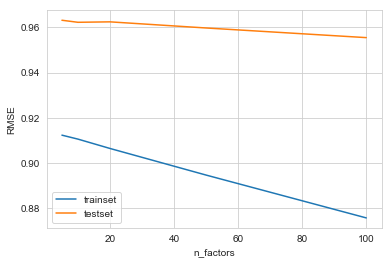

In [694]:
# alternatively we can use below single param search for hyper parameter opt 

n_factors = [5,10,20,50, 100]
results_train_n_factors = []
results_test_n_factors = []

for n_factor in n_factors:
    algo_svd = SVD(n_factors=n_factor, biased=True, lr_all=0.005, reg_all=0.4, n_epochs=10)
    result = cross_validate(algo_svd, data=data, cv=5, verbose=False, return_train_measures=True, n_jobs=-1)
    results_train_n_factors.append(sum(result['train_rmse']/5))
    results_test_n_factors.append(sum(result['test_rmse']/5))
 
plt.plot(n_factors, results_train_n_factors, label='trainset')
plt.plot(n_factors, results_test_n_factors, label='testset')
plt.xlabel("n_factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [697]:
# using non-negative matrix factorization 

param_grid = {'n_factors':[20, 30, 50, 75,100],'n_epochs': [5, 10], 'biased':[False, True],
              'reg_pu': [0.4, 0.6], 'reg_qi':[0.4, 0.6], 'reg_bu':[0.4, 0.6], 'reg_bi':[0.4, 0.6],  
              'lr_bu': [0.002, 0.005], 'lr_bi':[0.002, 0.005]}

gs_nmf = GridSearchCV(NMF, param_grid = param_grid, measures=['rmse'], n_jobs=-1, cv=5)

In [698]:
gs_nmf.fit(data)

In [699]:
print(f"The best model rmse score is {gs_nmf.best_score['rmse']}")
print(f"The best model parameters are {gs_nmf.best_params['rmse']}")

algo_nmf = gs_nmf.best_estimator['rmse']

result_nmf = cross_validate(algo_nmf, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_nmf = algo_nmf.fit(trainset).test(testset)

The best model rmse score is 0.7141717444684814
The best model parameters are {'n_factors': 100, 'n_epochs': 10, 'biased': False, 'reg_pu': 0.4, 'reg_qi': 0.4, 'reg_bu': 0.6, 'reg_bi': 0.6, 'lr_bu': 0.005, 'lr_bi': 0.005}
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7174  0.7012  0.7126  0.7193  0.7184  0.7138  0.0067  
MAE (testset)     0.3996  0.3913  0.3972  0.4016  0.3973  0.3974  0.0035  
RMSE (trainset)   0.5311  0.5365  0.5316  0.5315  0.5309  0.5323  0.0021  
MAE (trainset)    0.2757  0.2799  0.2762  0.2768  0.2762  0.2770  0.0015  
Fit time          3.15    3.16    3.15    3.09    2.97    3.11    0.07    
Test time         0.12    0.13    0.11    0.12    0.10    0.11    0.01    


In [700]:
# using svd++
param_grid = {'n_factors':[20, 30, 50, 75,100],'n_epochs': [5, 10], 
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs_svdpp = GridSearchCV(SVDpp, param_grid = param_grid, measures=['rmse'], n_jobs=-1, cv=5)

In [701]:
gs_svdpp.fit(data)

In [703]:
print(f"The best model rmse score is {gs_svdpp.best_score['rmse']}")
print(f"The best model parameters are {gs_svdpp.best_params['rmse']}")

algo_svdpp = gs_svdpp.best_estimator['rmse']

result_svdpp = cross_validate(algo_svdpp, data, cv=5, verbose=3,
                              return_train_measures=True, n_jobs=-1)
predictions_svdpp = algo_svdpp.fit(trainset).test(testset)

The best model rmse score is 0.9533041588403851
The best model parameters are {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9540  0.9440  0.9645  0.9575  0.9433  0.9527  0.0081  
MAE (testset)     0.7492  0.7405  0.7491  0.7485  0.7395  0.7453  0.0044  
RMSE (trainset)   0.8681  0.8694  0.8651  0.8694  0.8719  0.8688  0.0022  
MAE (trainset)    0.6811  0.6831  0.6795  0.6820  0.6847  0.6821  0.0018  
Fit time          22.63   22.94   22.70   23.10   23.24   22.92   0.23    
Test time         0.45    0.46    0.46    0.43    0.39    0.44    0.03    


In [705]:
import surprise
# probablistic factorization

class ProbabilisticMatrixFactorization(surprise.AlgoBase):
# Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean

In [708]:
gs_prob_factorization = GridSearchCV(ProbabilisticMatrixFactorization, 
                                     param_grid={'learning_rate':[0.005,0.01],'num_epochs':[5,10],'num_factors':[10,20]},
                                     measures=['rmse', 'mae'], cv=2)
gs_prob_factorization.fit(data)

In [712]:
print(f"The best model rmse score is {gs_prob_factorization.best_score['rmse']}")
print(f"The best model parameters are {gs_prob_factorization.best_params['rmse']}")

# algo_prob_factorization = gs_prob_factorization.best_estimator['rmse']

# result_prob_factorization = cross_validate(ProbabilisticMatrixFactorization, data, cv=5, verbose=3)
# predictions_prob_factorization = algo_prob_factorization.fit(trainset).test(testset)

The best model rmse score is 1.5316887811750801
The best model parameters are {'learning_rate': 0.01, 'num_epochs': 10, 'num_factors': 20}


In [714]:
kSplit = surprise.model_selection.KFold(n_splits=10,shuffle=True)
for train,test in kSplit.split(data):
    bestVersion = ProbabilisticMatrixFactorization(learning_rate=0.01, num_epochs=10, num_factors=20)
    bestVersion.fit(train)
    prediction = bestVersion.test(test)
    accuracy.rmse(prediction,verbose=True)

RMSE: 1.0193
RMSE: 0.9792
RMSE: 1.0423
RMSE: 0.9915
RMSE: 1.0218
RMSE: 0.9960
RMSE: 1.0063
RMSE: 1.0378
RMSE: 0.9991
RMSE: 0.9904


In [ ]:
# # Things to do:
# 0- How to incorporate user's feedback about an item (similar to tag in movie dataset)
# 1- Use ligth FM for more advanced models
# 2- Estimate Factorization Machine to incorporate users feedback
# 3- Tensor factorization
# 4- restricted boltzman machine + variational autoencoders + other deep neural net approaches
# 5- evolution of taste over a time in rec system (e.g. hidden markov models, sequential models, path-dependent rec, etc.)
# 6- deployment batch inferencing (update the model over a night) or online inferencing ... 

In [729]:
# using lightfm package for more advanced rec system
import lightfm

In [ ]:
# Weighted Approximate-Rank Pairwise
# (is a implicit models that treats alll interaction as a positive signal and those product that a user did not interacted 
# are assumed to implicitly dislike.)

In [716]:
from lightfm.datasets import fetch_movielens

data = fetch_movielens(min_rating=5.0)

In [720]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 19048 stored elements in COOrdinate format>

In [725]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [731]:
# model_warp = LigthFM(loss='warp')
# # model_wrap.fit(X, epochs=30)

In [ ]:
# In the final round of code review I need to clean up and make some of the tasks automated + 
# +define some test func (unit+consistency)

In [186]:
def randomly_dropping_cases(df, user_var, item_var, count_num, frac, random_state):
    """ This function randomly select users and item with specific number of ratings.
    Input:
        df = pandas dataframe
        user_var = string, indicating the name of the column with user id
        item_var = string, indicating the name of the column with item id
        count_num = int, to select users or item with specific count values
        frac = float, using to select a portion of user or items 
        random_state = int, for reproducibility
        
    Output:
        dropped_user 
        dropped_items
        df_new
    """
    df_user = df.groupby(user_var).size()_reset_index(name='count')
    df
    
df_temp1 = df_clean.groupby

0.6661129155204984

In [ ]:
def bayesian_avg(df):
    bayesian_avg = (c*m + df.sum())/(c+ratings.count())
    return bayesian_avg


def top_n_items_mean(mean_fun, df, n):
    """This function return top n items based on basic or bayesian mean for a given data"""
    stats = df.grouby('ProductId')[['Score']].agg(['count', 'mean'])
    stats.columns = stats.columns.droplevel()
    
    if mean_fun == 'basic':
        result = ...stats.sort_values('mean', ascending=False)[:topn]
        
    elif mean_fun == 'bayesian':
        c = stats['count'].mean()
        m = stats['mean'].mean()
        result = 